# Field population statistical analyses

## no choice Experiment

this script conducts the statistics for the no-choice experiment intake target of field caught Australian plauge locusts

Specifics for the experiment design can be found in the publication.

For this section, I (Douglas Lawton) did not calculate the specific growth time, this was done in excel. I will mnot reproduce it here

In [1]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("tidyverse", "mgcv", "MuMIn", "multcomp", "gratia", 
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","emmeans")

load_packages(packages)

i_am('README.md')

# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser



Attaching package: ‘gratia’


The following object is masked from ‘package:stringr’:

    boundary



Attaching package:

## Data import

This code reads a CSV file containing no choice IT data, cleans the column names, converts specific columns to factors.

column descriptions:

-   **died_experiment**: Indicates whether the locust individual died during the experiment.
-   **diet**: Specifies the type of diet the locust individual was on.
-   **diet_no**: Numeric identifier for a specific diet dish
-   **sex**: The sex of the locust individual.
-   **initial_weight_g**: The initial weight of the locust individual in grams.
-   **days1_3_total_g**: Total amount consumed by the locust individual from days 1 to 3 in grams.
-   **days1_6_total_g**: Total amount consumed by the locust individual from days 1 to 6 in grams.
-   **days1_9_total_g**: Total amount consumed by the locust individual from days 1 to 9 in grams.
-   **adult_mass_g**: The body mass of the locust individual when it reached adulthood, measured in grams.
-   **final_mass_g_dec3**: The final mass of the locust individual at the 5th instar stage, recorded on December 3rd, in grams.
-   **dev_time_if_molted_days**: Development time in days if the locust individual molted.
-   **time_in_5th_instar_days**: Time spent in the 5th instar stage if the locust individual did not molt, measured in days.
-   **dev_time_with_5th_instar_days**: Development time including days spent in the 5th instar stage for locust individual that did not molt, measured in days.
-   **specific_growth_rate_ln_mb**: The specific growth rate, calculated as the growth rate normalized by initial body mass and time.

In [4]:
no_choice <- read_csv(here("data/raw/field_populations/confined_diet.csv"),show_col_types = FALSE) |>
    clean_names() |>
    rename(
        died_experiment = died_during_experiment,
        diet = diet,
        diet_no = diet_no,
        sex = sex,
        initial_weight_g = locust_initial_weight_g,
        days1_3_total_g = days1_3_consumed_total_g,
        days1_6_total_g = days1_6_consumed_total_g,
        days1_9_total_g = days1_9_consumed_total_g,
        adult_mass_g = adult_body_mass_g,
        final_mass_g_dec3 = final_mass_g_5th_instar_recorded_on_dec_3,
        dev_time_if_molted_days = development_time_if_molted_days,
        time_in_5th_instar_days = time_in_5th_instar_if_not_molt_days,
        dev_time_with_5th_instar_days = development_time_with_days_in_5th_instar_for_those_not_yet_molted_days,
        specific_growth_rate_ln_mb = specific_growth_rate_ln_mb_final_mb_initial_time) |>
    drop_na(specific_growth_rate_ln_mb)

head(no_choice)

# Raw data visualization

I am using `ggpairs` to make this section pithy

In [5]:
numeric_columns <- c("initial_weight_g","specific_growth_rate_ln_mb","dev_time_with_5th_instar_days")

my_dens <- function(data, mapping,...) {
  ggplot(data = data, mapping=mapping) +
    geom_density(..., alpha = 0.7, fill = NA) 
}


sex_raw_graph <- no_choice |>
    dplyr::select(!c(died_experiment,diet,diet_no,molted)) |>
    ggpairs(aes(color=sex),columns = numeric_columns,diag = list(continuous = my_dens))  +
    scale_colour_manual(values=c('#e5a335','#96410e'))  +
    scale_fill_manual(values=c('#e5a335','#96410e')) +
    theme_pubr()

diet_raw_graph <- no_choice |>
    dplyr::select(!c(died_experiment,diet_no,molted)) |>
    ggpairs(aes(color=diet),columns = numeric_columns,diag = list(continuous = my_dens))  +
    scale_colour_manual(values=c('#e5a335', '#96410e', '#556219', '#418979'))  +
    theme_pubr()


In [6]:
# Define the output directory
output_dir <- here('output/field_populations/raw_visualization/')

# List of plots and their corresponding file names
plots <- list(
  "no_choice_experiment_sex_raw_graph" = sex_raw_graph,
  "no_choice_experiment_diet_pair_raw_graph" = diet_raw_graph
)

# Loop through each plot and save it
for (name in names(plots)) {
  ggsave(
    filename = file.path(output_dir, paste0(name, ".png")),
    plot = plots[[name]],
    width = 10, height = 10, dpi = 300
  )
}

## Model building

### General Additive Models (GAM) for Carbohydrate and Protein Consumption of Field Populations

### No Choice Experiments

In this analysis, we are exploring the relationship between carbohydrate and protein consumption using General Additive Models (GAMs) with different explanatory variables for two field popualtions of locusts and no choice experiments. Each model assumes a gaussian distribution for the response.

### Modeling Overview:

We are regressing the days to fifth instar and the specific growth rate on the sex (male or female) and diet (four restricted diets). More information can be found within the methods section of the paper.

Both dependent variables will undergo the same model selection criteria:

**Model 1: Non-linear Relationship with Initial Mass**

Formulas: - specific_growth_rate ~ population + diet_pair + sex + s(initial_weight_g, k = 15) - dev_time_with_5th_instar_days ~ population + diet_pair + sex + s(initial_weight_g, k= 15)

Description: This model allows for a non-linear relationship between the initial mass of the subject and the consumption of carbohydrates and proteins. The smoothing function s(initial_mass_g, k=30) captures the non-linear effects with a basis dimension of 30.

**Model 2: Linear Relationship with Initial Mass**

Formulas: - specific_growth_rate ~ population + diet_pair + sex + initial_weight_g - dev_time_with_5th_instar_days ~ population + diet_pair + sex + initial_weight_g

Description: In this model, the relationship between initial mass and nutrient consumption is assumed to be linear. This model tests whether a simpler, linear approximation can adequately describe the relationship.

**Model 3: Excluding Initial Mass**

Formula: - specific_growth_rate ~ population + diet_pair + sex - dev_time_with_5th_instar_days ~ population + diet_pair + sex

Description: This model excludes the initial mass as an explanatory variable, focusing only on population, sex, and diet pair to explain the variation in carbohydrate and protein consumption.

**Model 4: Null Model**

Formula: - specific_growth_rate ~ 1 - dev_time_with_5th_instar_days ~ 1

Description: The null model includes only an intercept, serving as a baseline to compare the other models. This model should represent the worst fit to the data, as it assumes no relationship between the predictors and the response variables.

In [19]:
# Model 1: Non-linear Relationship with Initial Mass

sgr_mod1 <-gam(specific_growth_rate_ln_mb ~ diet + sex + s(initial_weight_g,k=15), 
               data=no_choice,select=TRUE, family=gaussian())

dev_mod1 <-gam(dev_time_with_5th_instar_days  ~ diet + sex + s(initial_weight_g,k=15), 
               data=no_choice,select=TRUE, family=gaussian())

# Model 2: Linear Relationship with Initial Mass

sgr_mod2 <-gam(specific_growth_rate_ln_mb ~ diet + sex + initial_weight_g, 
               data=no_choice,select=TRUE, family=gaussian())

dev_mod2 <-gam(dev_time_with_5th_instar_days  ~ diet + sex + initial_weight_g, 
               data=no_choice,select=TRUE, family=gaussian())

# Model 3: Excluding Initial Mass

sgr_mod3 <-gam(specific_growth_rate_ln_mb ~ diet + sex, 
               data=no_choice,select=TRUE, family=gaussian())

dev_mod3 <-gam(dev_time_with_5th_instar_days  ~ diet + sex, 
               data=no_choice,select=TRUE, family=gaussian())

# Model 4: Null Model

sgr_mod4 <-gam(specific_growth_rate_ln_mb ~ 1, 
               data=no_choice,select=TRUE, family=gaussian())

dev_mod4 <-gam(dev_time_with_5th_instar_days  ~ 1, 
               data=no_choice,select=TRUE, family=gaussian())

### Model Selection:

After fitting these models, we will compare them using the following criteria:

-   Akaike Information Criterion (AIC): A measure of the relative quality of the models for a given dataset, considering both goodness of fit and model complexity.
-   Bayesian Information Criterion (BIC): Similar to AIC, but with a stronger penalty for models with more parameters.
-   Corrected AIC (AICc): AIC adjusted for small sample sizes, ensuring a more reliable comparison when sample sizes are limited. By examining the AIC, BIC, and AICc values, we will select the best model for explaining carbohydrate and protein consumption.

In [21]:

# Define the function
calculate_model_selection <- function(models) {
  
  bic <- BIC(models[[1]], models[[2]], models[[3]], models[[4]]) |>  # Bayesian Information Criterion
    mutate(deltaBIC = BIC - min(BIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model, BIC, deltaBIC)
  
  aic <- AIC(models[[1]], models[[2]], models[[3]], models[[4]])  |>  # Akaike Information Criterion
    mutate(deltaAIC = AIC - min(AIC)) |>
    rownames_to_column('model') |>
    dplyr::select(model, AIC, deltaAIC)
  
  aicc <- AICc(models[[1]], models[[2]], models[[3]], models[[4]])  |>  # AIC adjusted for small sample size
    mutate(deltaAICc = AICc - min(AICc)) |>
    rownames_to_column('model') |>
    dplyr::select(model, AICc, deltaAICc)
  
  model_selection_tables <- bic |>
    left_join(aic, by = 'model') |>
    left_join(aicc, by = 'model')
  
  return(model_selection_tables)
}

# Apply the function to the two model sets

sgr_models <- list(sgr_mod1, sgr_mod2, sgr_mod3, sgr_mod4)
dev_models <- list(dev_mod1, dev_mod2, dev_mod3, dev_mod4)

sgr_model_selection <- calculate_model_selection(sgr_models)
dev_model_selection <- calculate_model_selection(dev_models)


## Model Diagnostics

To see how well these models fit, I will run `mgcv::gam.check()` on it

### Specific growth rate diagnostic plots

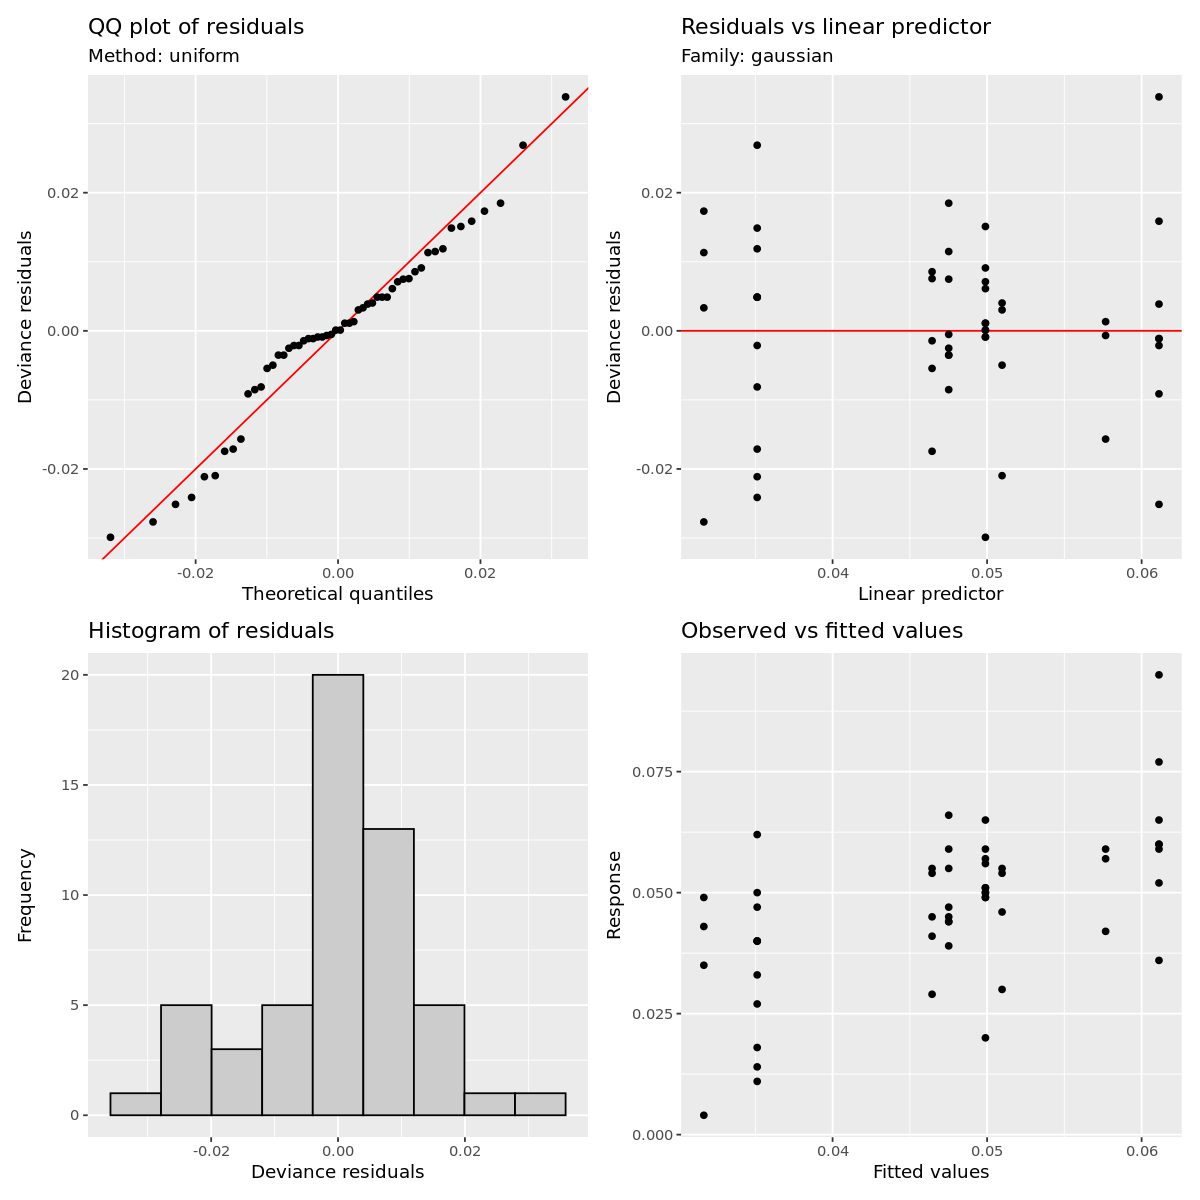

In [22]:
gratia::appraise(sgr_mod1)

### Development time diagnostic plots

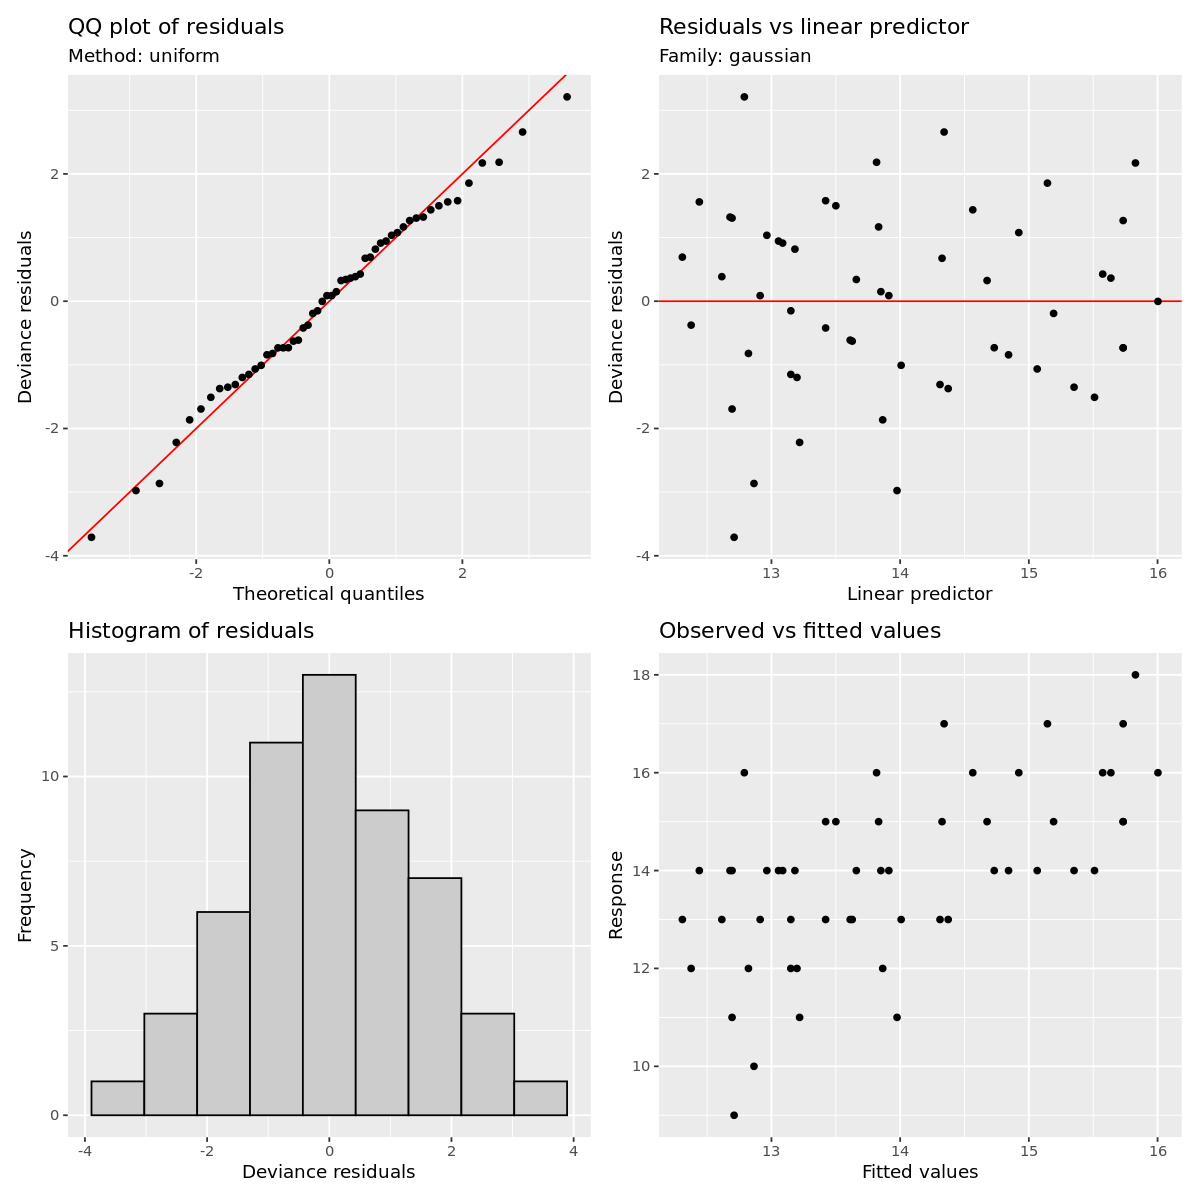

In [23]:
gratia::appraise(dev_mod1)

These diagnostic plots indicate these models are decently fit.

now lets calculate the model selection criteria

In [24]:
# Load necessary libraries
library(dplyr)
library(broom)

# Define the function
calculate_model_selection <- function(models) {

  bic <- BIC(models[[1]], models[[2]], models[[3]], models[[4]]) |>  # Bayesian Information Criterion
    mutate(deltaBIC = BIC - min(BIC), across(where(is.numeric), ~ round(., 3))) |>
    rownames_to_column('model') |>
    mutate(model = model) |>
    dplyr::select(model, BIC, deltaBIC)
  
  aic <- AIC(models[[1]], models[[2]], models[[3]], models[[4]])  |>  # Akaike Information Criterion
    mutate(deltaAIC = AIC - min(AIC), across(where(is.numeric), ~ round(., 3))) |>
    rownames_to_column('model') |>
    mutate(model = model) |>
    dplyr::select(model, AIC, deltaAIC)
  
  aicc <- AICc(models[[1]], models[[2]], models[[3]], models[[4]])  |>  # AIC adjusted for small sample size
    mutate(deltaAICc = AICc - min(AICc), across(where(is.numeric), ~ round(., 3))) |>
    rownames_to_column('model') |>
    dplyr::select(model, AICc, deltaAICc)
  
  model_selection_tables <- bic |>
    left_join(aic, by = 'model') |>
    left_join(aicc, by = 'model')
  
  return(model_selection_tables)
}

# Apply the function to the two model sets

sgr_models <- list(sgr_mod1,sgr_mod2, sgr_mod3, sgr_mod4)
dev_models <- list(dev_mod1, dev_mod2, dev_mod3, dev_mod4)

sgr_model_selection <- calculate_model_selection(sgr_models) |>
    mutate(experiment = 'no_choice_experiment',
           physiology_parameter = 'specific_growth_rate')

dev_model_selection <- calculate_model_selection(dev_models) |>
    mutate(experiment = 'no_choice_experiment',
           physiology_parameter = 'development_time')




In [25]:
# The positioning in the list represents the model. e.g. mod1 == models[[1]]

sgr_model_selection |>
    arrange(deltaAIC)

dev_model_selection |>
    arrange(deltaAIC)

no_choice_experiment_model_selection_criteria_results <- sgr_model_selection |> 
    rbind(dev_model_selection)

In [26]:
summary(sgr_mod1)
summary(sgr_mod3)


Family: gaussian 
Link function: identity 

Formula:
specific_growth_rate_ln_mb ~ diet + sex + s(initial_weight_g, 
    k = 15)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.061124   0.004238  14.422  < 2e-16 ***
diet21p:21c -0.011232   0.005318  -2.112   0.0398 *  
diet35p:7c  -0.010155   0.005885  -1.726   0.0907 .  
diet7p:35c  -0.026003   0.005387  -4.827  1.4e-05 ***
sexM        -0.003453   0.004051  -0.852   0.3982    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df F p-value
s(initial_weight_g) 3.899e-07     14 0   0.727

R-sq.(adj) =  0.283   Deviance explained = 33.7%
GCV = 0.00020294  Scale est. = 0.00018415  n = 54


Family: gaussian 
Link function: identity 

Formula:
specific_growth_rate_ln_mb ~ diet + sex

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.061124   0.004238  14.422  < 2e-16 ***
diet21p:21c -0.011232   0.005318  -2.112   0.0398 *  
diet35p:7c  -0.010155   0.005885  -1.726   0.0907 .  
diet7p:35c  -0.026003   0.005387  -4.827  1.4e-05 ***
sexM        -0.003453   0.004051  -0.852   0.3982    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


R-sq.(adj) =  0.283   Deviance explained = 33.7%
GCV = 0.00020294  Scale est. = 0.00018415  n = 54

In [27]:
summary(dev_mod1)
summary(dev_mod2)


Family: gaussian 
Link function: identity 

Formula:
dev_time_with_5th_instar_days ~ diet + sex + s(initial_weight_g, 
    k = 15)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  13.0509     0.4975  26.232  < 2e-16 ***
diet21p:21c   0.8223     0.6173   1.332   0.1891    
diet35p:7c    1.6634     0.6630   2.509   0.0155 *  
diet7p:35c    2.7049     0.6027   4.488 4.46e-05 ***
sexM         -1.2721     0.7548  -1.685   0.0984 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df     F p-value  
s(initial_weight_g) 0.7555     10 0.309  0.0487 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.31   Deviance explained = 37.2%
GCV = 2.5774  Scale est. = 2.3027    n = 54


Family: gaussian 
Link function: identity 

Formula:
dev_time_with_5th_instar_days ~ diet + sex + initial_weight_g

Parametric coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       15.7797     1.5548  10.149 1.56e-13 ***
diet21p:21c        0.9166     0.6244   1.468   0.1487    
diet35p:7c         1.7091     0.6645   2.572   0.0133 *  
diet7p:35c         2.7157     0.6028   4.505 4.24e-05 ***
sexM              -1.6155     0.8292  -1.948   0.0573 .  
initial_weight_g -21.0476    10.4069  -2.022   0.0487 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


R-sq.(adj) =   0.31   Deviance explained = 37.5%
GCV = 2.5906  Scale est. = 2.3027    n = 54

## model selection summary

For both specific growth rate and development model selection criteria differed slightly.

#### Specific growth rate

Model selection criteria could not discern between model 1 (non-linear relationship with initial mass) and model 3 (excluding initial mass entirely). However inspecting the model summary, the paramteric parameters really dont change between the models and the non-linear non-parametric term is in sigificant in model 1. As such, I will go with the most simplistic model, which is model 3.

#### Development time

Model selection criteria could not discern between model 1 (non-linear relationship with initial mass) and model 2 (linear relationship with initial mass). However inspecting the model summary, these model coefficients ended up looking very similar. I will go with model 2 because it matches the results of model 1 and is more simplistic.

## Key Findings:

-   Development Time Model: Diet composition and initial weight significantly impact development time. Specifically, a diet high in carbohydrates (7p:35c) or high in protein significantly extends development time as compared to the reference level of 14p:24c), while increased initial weight shortens it. There is also a marginally significant trend suggesting that males may develop slightly faster than females. Overall, the model explains 37.5% of the variation in development time.

-   Specific Growth Rate Model: Diet also plays a critical role in specific growth rate, with a high-carbohydrate diet (7p:35c) or high-protein diet significantly reducing growth rate as compared to the reference level of 14p:24c). Initial weight does not appear to have a significant effect on growth rate in this model, nor does sex. The model explains 33.7% of the variation in growth rate.

## Posthoc comparison between diet pair levels

In [28]:

development_time_emms <- emmeans(dev_mod2, ~ diet)
development_time_contrasts <- contrast(development_time_emms, method = "pairwise") |> tidy()

specific_growth_rate_emms <- emmeans(sgr_mod3, ~ diet)
specific_growth_rate_contrasts <- contrast(specific_growth_rate_emms, method = "pairwise") |> tidy()

## Model outputs

I am going to get the estimated marginal means for `diet`,`sex`, and `initial_weight` for both the final models

I will add this as a new dataframe

I will also write out all models to disks

In [29]:
no_choice_exp_preds <- expand.grid(
  initial_weight_g = seq(min(no_choice$initial_weight_g), max(no_choice$initial_weight_g), length.out = 10),
  diet = unique(no_choice$diet),
  sex = unique(no_choice$sex)
)

# Predict carbohydrate consumption
no_choice_exp_preds$pred_specific_growth_rate <- predict(sgr_mod3, newdata = no_choice_exp_preds, type = "response")

# Predict protein consumption
no_choice_exp_preds$pred_development_time <- predict(dev_mod2, newdata = no_choice_exp_preds, type = "response")

no_choice_exp_preds |> head()

In [30]:
# Writing out the predictions
write.csv(no_choice_exp_preds,here('data/processed/field_populations/no_choice_experiment_predictions.csv'),row.names=FALSE)

# Writing out the model selection criteria
write.csv(no_choice_experiment_model_selection_criteria_results, here("output/field_populations/no_choice_experiment_model_selection_criteria_results.csv"),row.names=FALSE)


# Writing out the contrasts for sepcific growth rate and development time
write.csv(development_time_contrasts, here("output/field_populations/no_choice_experiment_development_time_emm_contrasts.csv"),row.names=FALSE)
write.csv(specific_growth_rate_contrasts, here("output/field_populations/no_choice_experiment_specific_growth_rate_emm_contrasts.csv"),row.names=FALSE)


# Saving models
## Combine the lists into a single list
models <- list(sgr_models = list(sgr_mod1, sgr_mod2, sgr_mod3, sgr_mod4),
               dev_models = list(dev_mod1, dev_mod2, dev_mod3, dev_mod4))

## Save the combined list to an RDS file
saveRDS(models, here("output/field_populations/model_objects/no_choice_experiment_models.rds"))